# Self-driving car Nano Degree: Advanced Lane Lines

## Project feeling

In terms of code, I set for myself the goal to organise all the previous work in a single, easy to use piece of software. The size and complexity of a few functions was becoming too large to work comfortably in jupyter notebook. In addition, the requirement to track the lines from frame to frame and hints in the classroom pushed me toward an object oriented implementation. I am a beginner in Python, so this project was an opportunity to become familiar with Python modules, object-oriented features and also with the Python debugger, which saved me. Until this project, I knew nothing about the debugger.

Regarding the advanced lane lines project itself, I think it can be improved a lot for future students, and so can the course leading to it. The shortcomings from the course weight on the project and make it very academic in nature. Tracking items from frame to frame is introduced, but the Kalman filters, which are the right tool for the task, are only introduced at the beginning of term 2.

Let's summarize the project:

* Compute the camera calibration and apply distortion correction to images;
* Use color selection and masking to find lane line pixels on images;
* Use gradient approaches to find the lane lines;
* Warp image to bird-eye view in order to extract the geometry without the perspective effect;
* Render the extracted geometry and map it back on the original image;
* Compute the road curvature using the extracted geometry;
* Loop to process videos, and possibly include information from recent images in the detection tool chain.

I believe that this part of the course puts too much emphasis on colorspaces, without clearly making the point. Students understand what colorspaces are (I already knew), but the course does not explain how they connect with the topic. That's where we are left to believe that a robust lane detection algorithm can be built using colorspaces to look at different representations of pixel data. But that's plain wrong and misleading.

In the first lane lanes project, we boxed interesting pixels in a cube in RGB space. The tree on the side of the road projected a shadow which turned the white in gray, and it was difficult to continue tracking. So what are the more advanced methods of this project offering ?

Colorspaces index the available colors in different ways. Many tend to have hue and/or luminosity / luminance as axes. If we want to be robust to shadows, we need a rather large box in RGB space. The diagonal of that box extends from the bright white or yellow of a sunlit line, to the darker shade of the same color seen in a shadow. In different colorspaces, the boundaries defined by thresholds on various axes define other types of surfaces than cube faces in RGB space. But at the end of the process, we just delimited a volume in the colorspace (however you index it), which corresponds to "yellow" and "white" lane line pixels seen in various conditions. Using multiple colorspaces enables us to refine the definition of this volume, using separation surfaces which are not parallel to a constant R, a constant G or a constant B plane. We are doing by hand a job that supervised machine learning algorithms can do automatically.

The next figure is an example of annotated test images, that I used to automatically evaluate preprocessing pipelines. The alpha layer is used to isolate pixels belonging to lane boundaries, including the wall.

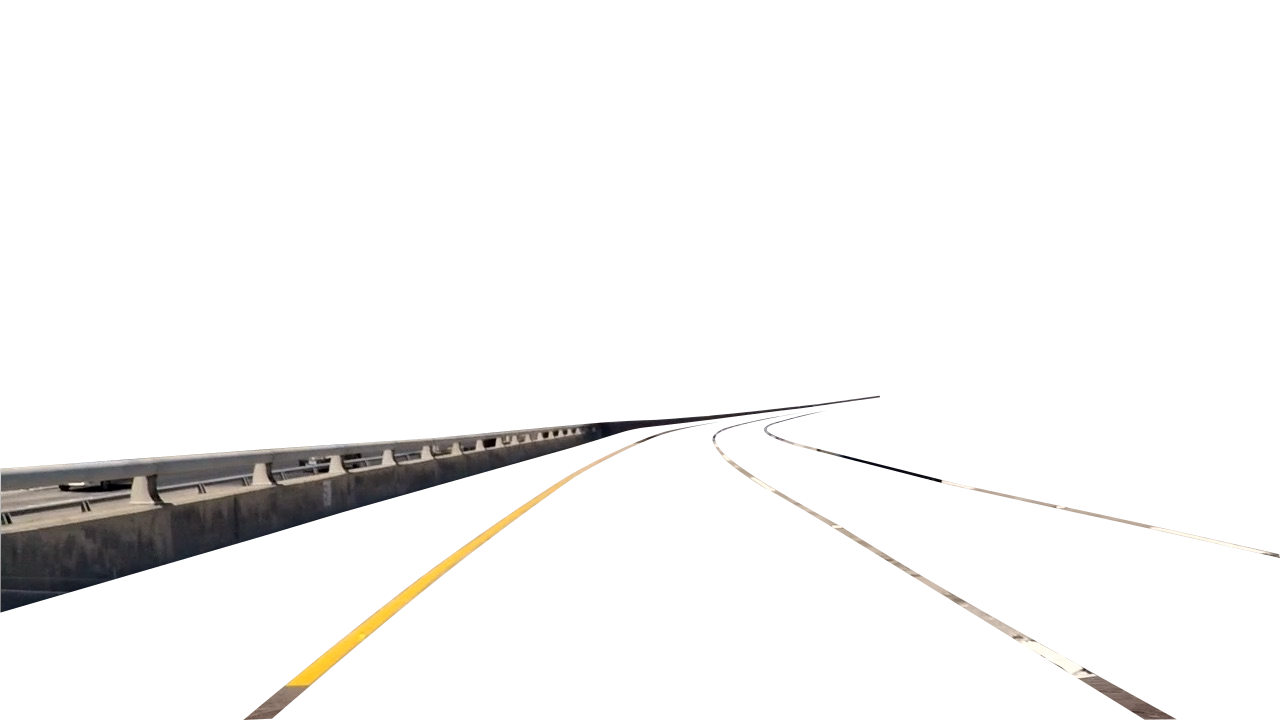

The academic side of the approach shows when it becomes apparent that any surface in a scene, can appear in any color. The course lacks an in-depth discussion of what color is, and why an approach in the colorspaces cannot work in real life. It can only work on sunny days. Each material can reflect color in a specific fashion, filtering in its own way the light components present in the incident light. Some materials can alter the frequency of light, shifting the color. Diffraction on water droplets make rainbow colors appear at pixel level. 

The lane lines can appear in any arbitrary color. This effect is clearly visible in neon lit street scenes under the rain: images show light from the colored neons reflected by water more than the lines. Under heavy rain at night, my experience as a driver tells me that it is not really possible to rely on the lane lines farther out than a few meters. But even in sunlight, we could have a color altering medium between the camera and the line, for instance a cloud of bluish engine exhaust, and the more we try to narrow what yellow and white mean for lane lines, the less robust we are to lighting, colored gases and rain, and paint color variations. Here in France, we also have blue lines delimiting time-limited parking spaces.

The next part of the course, on classifiers, gives us the right tools to classify pixels which can be lane lines, from those that cannot using machine learning approaches. And we could also have used a deep neural network to model this area of colorspace. 

## Personal objectives

I have set for myself the following goals, in addition to the objectifs stated in the Udacity project specifications:

* Deeper knowledge of Python
* Reusable library
* Ready for GPU implementation
* Robust algorithms


### The RoadImage library

The RoadImage library includes three classes:
* The RoadImage class, which relies on the other two;
* The Line abstract class, which encapsulates geometries;
* The CameraCalibration class, which stores camera calibration data and does all the 3D scene calculations.

In total, there are nearly four thousand lines of Python code, but a significant proportion of those are a consequence of my inexperience with that programming language.

`RoadImage` is a specialization of the `numpy.ndarray` class. As a first approach to Python classes, it is not a straightforward example, but extending `numpy` is remarkably well documented.

A RoadImage instance is a collection of images (not a sequence, but possibly multiple camera images in parallel) represented as a N-dimensional `ndarray` where `N >= 3`. The last three dimensions must be height, width and depth of images, and even monochrome images have a depth dimension, equal to 1.

Internally, decorators flatten the collection, so that all the methods can rely on receiving 4 dimension arrays, where the dimensions are:

* 0: collection
* 1: height
* 2: width
* 3: channels (depth)

On top of methods available to all `numpy` arrays, the library offers the following additions:

* Image history:
  * parents
  * crop\_parents
  * children
  * list\_children
  * find\_child
  * shares\_data
  * copy
  * unlink
  * find\_common\_ancestor
  * find_op
  * select\_ops
  * get_crop
  * pretty\_print\_ops


* Data reorganization and views:
  * make_collection
  * flatten
  * channel
  * channels
  * rgb
  * crop


* Image transformation:
  * Per pixel
    * **convert_color**: Changes the colorspace.
    * to_grayscale
    * to_int
    * to_float
    * invert
    * **threshold**: Makes a binary image from a color or grayscale image.
    * apply\_mask
    * combine_masks
    
  * Global and morphological operators
    * **undistort**: Corrects distortion in an image using calibration data.
    * despeckle
    * dilate
    * erode
    * **extract\_lines**: Complex and slow image preprocessing pipeline.
    * resize
    * **gradients**: Optimized computation of one or more gradients, almost as explained in the classroom.
    * **integrate**: Turn signed gradient images back into unsigned ones.
    * **normalize**: Normalize pixel values to 100%, per image, per channel or per line.
    * warp_size
    * _warp_
    * _unwarp_
    * **curves**: Generic curve detection algorithm.
    * **find\_lines**: Final pipeline.
    * **centroids**: Enhanced centroids algorithm (not used).
    
    
* Information and utilities:
  * get_size : Get the width and depth of an image.
  * save : Save using the right channel order convention (matplotlib).
  * show : Safe image display layer atop imshow.

Key algorithms have been substantially modified from the baseline. 

The library has three key characteristics that are not required for the project: 
1. It remembers the transformations applied to an image, checks that requested operations are valid on the instance, and can explain how an image was obtained;
2. It is independent of the underlying representation of geometries, which is encapsulated in a class Line;
3. It tries hard to evaluate the quality of the proposed solutions.

The history is maintained with the idea that pipelines in the future can be prototyped interactively, then saved and reused with a single `apply` method. The current library tracks which images must be updated when an upstream image is modified. It does not currently offer this fully interactive mode, but prevents changes to images which would require updating downstream images. In order to support this features, it makes a distinction between derivative images which are views (`shares_data()` returns `True`) and other images.

Pipelines could also possibly be "compiled" for different hardware, such as the GPU. In the current implementation, history is used to automate finding the right information in sequences of operations. For instance, it is possible to unwarp a warped, cropped image to the right crop size using the correct inverse transformation, because the `CameraCalibration` data associated to the `warp` operation and the crop size are retrieved from the history of the image. 

The history of an image is a directed acyclic graph, where an image can serve as the basis for several other

The library remembers if an image has been undistorted, has been warped or unwarped, is binary (i.e. from a `threshold` operation) or is a signed gradient. The method `show` has specific provisions to display signed gradient image, either using a red-green scale (red for negative parts) when there is a single channel, or taking the absolute value when there are 2 or 3 channels.

The library checks for common errors, such as:
* Forgetting to undistort before warping;
* Thresholding a binary image (usually gives a black image);
* Unwarping an image, that was not first warped;
* Applying logic operations with `combine_masks` or morphological operations to non-binary operands;
* Applying `invert` or `integrate` to unsigned images;
* etc.

All the methods in `RoadImage` which deal with lane line geometries, do so through an instance of class `Line`. More exactly, since `Line` is an abstract class, it is an instance of class `LinePoly`, which implements polynomial models of lane lines, as explained in the classroom. All the geometries are represented by arbitrary python tuples, called "keys", chosen by the caller, except for a few default ones.

The instance is shared by all the related road images. A single instance of `Line` can store many geometries in a dictionary. The only constraint on keys, is that they should be suitable as python dictionary keys, and of course, tuples are a good choice.

The `Line` class offers the following interface:
* Properties:
  * zero : returns ('zero',), the default key for the line defined by equation `y = 0` (read-only).
  * one : returns ('one',), the key for `y = 1`.
  * color : the line color in RGB or RGBA
  * blink : make the representation blink
  * width : line width in the representation
* Management methods:
  * delete : delete a stored geometry
  * copy : copy a geometry to access it through another key
  * stats : generic getter of custom data associated to a geometry
  * set : generic setter of custom data associated to a geometry
  * exist : test if keys correspond to existing geometries
* Geometric operations
  * **move** : change the origin and orientation of the reference axes (used to update lane lines by dead reckoning)
  * **delta** : resolves the origin/orientation change between two geometries, assuming they describe the same line from two different points of view (used to measure the car speed)
  * **fit** : generates a geometry fitted to given points
  * **blend** : generates a geometry based on two others, using either a weighted sum or a weighted average
  * **eval** : computes Y=f(X) and derivatives, for the given X and geometry
  * **tangent** : simplifies a geometry which keeping it tangent in a given point to the original one, up to a given order
  * curvature : computes the curvature of a geometry at the given points
* Graphical operations
  * draw : draws the geometry in an image, using the defined color and width
  * draw_area : draws and fills the area between two geometries

In addition the `Line` instance is an iterable, which yields the keys of all the geometries it stores (the last 60 frames). The `LinePoly` class implements a polynomial approximation of curves. It is the default implementation a program gets when calling `Line.Factory()`. A particular implementation has to define all the geometric operations excepted `curvature`, which is defined in terms of `eval`.

Some linear algebra is needed to implement `delta` and `tangent` for polynoms. Of course, `np.polyfit` is used to implement `fit`.

Because polynomial fitting relies on Vandermonde matrixes, it is well known that it is numerically unstable for large values of X and Y. The exponentiation of X creates a badly conditioned matrix. To improve this, making the Y as small as possible is a good idea. 

The method `fit` is key to our line finding application. The implementation of `Line.fit` does only one thing: it substract the reference curve from the set of points to fit, and checks if the problem is better conditioned. If it is the case, the improved problem is passed to the specific implementation of `fit`. Otherwise the original curve fitting problem is passed down.

`tangent` computes a lower order curve tangent to a given curve at a given point. In this context "tangent" is not limited to the value and the first derivative. If requested, `tangent` will compute a curve which matches the value and derivatives up to an arbitrarily high order. The solution at order zero is a constant y0 = P(x0). In the demonstration, `tangent` is used to simplify the old solutions which are used as hints to limit the search in the current frame.

`move` updates a geometry to reflect a change of origin. The current implementation is exact, but it is only useful if the displacement is known. In theory, the displacement can be computed using the method `delta`. However, it is more complicated to find the displacement between two polynomial curves, than the opposite. In the current implementation, `delta` works great if the second geometry to compare, is the result of processing the first one with `move`. The algorithm seems to be less reliable when the input data is not exactly right. Those methods are not used by the demonstration.

### Algorithms
#### Image Preprocessing
The first part of the project is the image preprocessing, which takes camera images, corrects distortion, and makes a binary image. There is no really good solution to this problem. 

I spent a considerable amount of time looking for the best possible settings, until I attempted to load one of the test images in Gimp, as a layer of a binary image. To my suprise, Gimp converted the camera image to a binary by a simple conversion to greyscale, followed by thresholding at 0.5. The result was clear, ready for warping, and the algorithm was robust, simple and really fast.

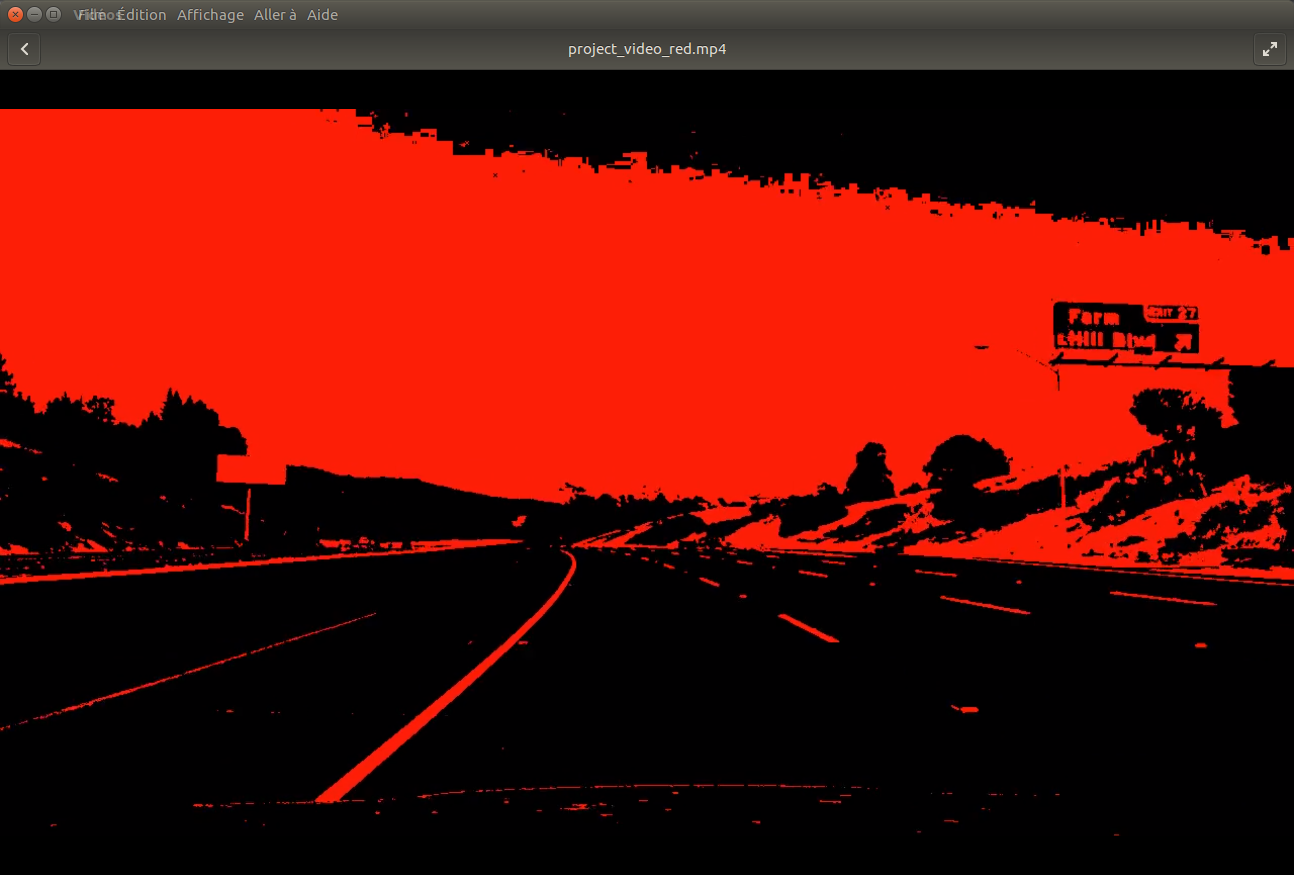

This algorithm is used to preprocess most frames (RoadImage.py, line 2921), however, when the asphalt is not dark enough, this simple algorithm fails and "blooms".

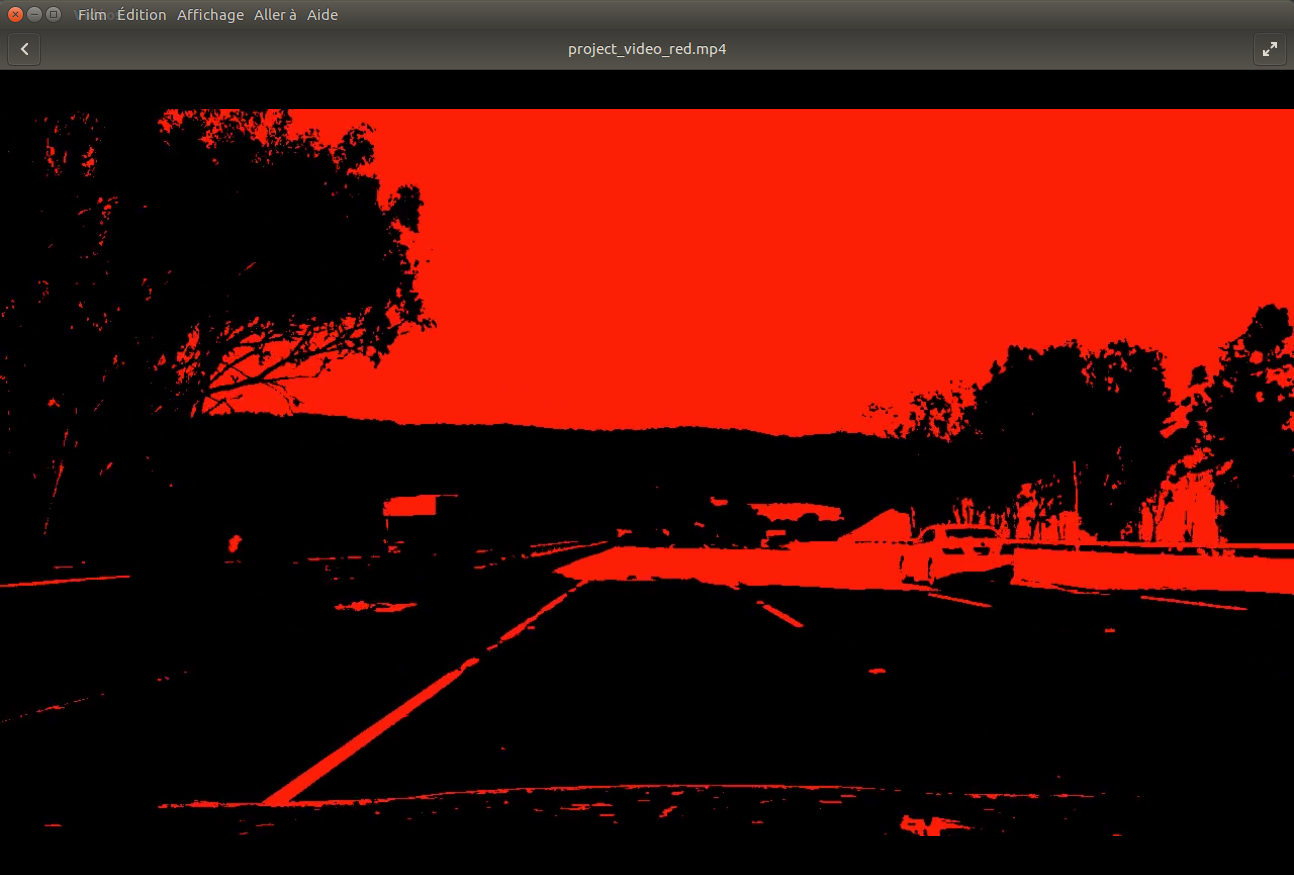

On the warped image, the blooming looks like a red tide coming from the top. The algorithm monitors for this condition by counting the number of lit pixels on each line of the warped binary image. The noise of both sides of the road and the two lane lines don't typically represent more than 160 cm of lightly colored stuff, or 80 pixels at the 2cm/pixel scale of my warped images.
```python
        gray = img.to_grayscale()
        gray = gray.threshold(mini = 0.5)

        overlay, orig = gray._warpo() #_warpo(gray)
        origin = (orig[0,0],orig[0,1])
        _, _,w,ch = overlay.shape

        sums = np.sum(overlay.astype(np.int),axis=(-2,-1))
        overlay = overlay.to_float()

        if np.max(sums[0,:]) > 80:
            # Light colored pavement ahead
```
When the simple algorithm fails, the image is reprocessed with the pipeline of the project walkthrough video. I decided to use this pipeline mainly because it is much faster than my own pipeline. The results are good enough to detect the lines. The next picture compares the binary images of the two pipelines.

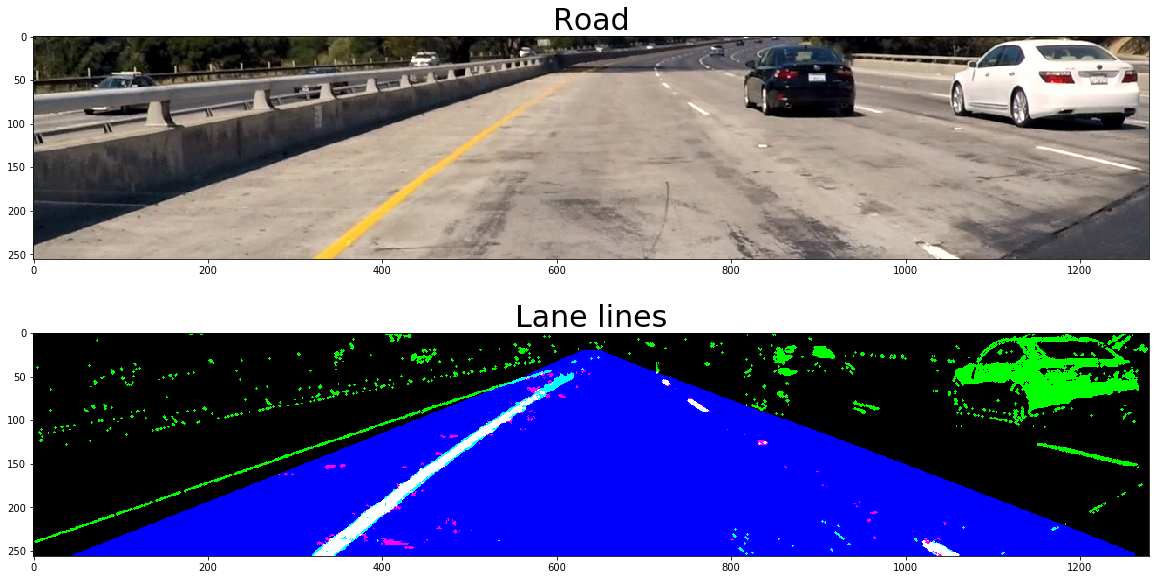

The image above shows the original camera image, cropped below the horizon line, and the result of image preprocessing. It is actually a set of three binary images which are shown as a single RGB image. Eight colors are possible for each pixel depending on the state of the pixel on each image. The blue channel (colors blue, magenta, cyan and white) shows simply the mask that is built into my pipeline. Only green pixels appear outside of this blue triangle, since the walkthrough video pipeline, which does not enforce any mask, is shown in the green channel (colors green, cyan and white). Finally my slow preprocessing routine is shown in the red channel (colors magenta and white).

It is clear that the preprocessing from the walkthrough video is better at distinguishing the lines in the distance (red circle).

#### Lane Line Geometry
The key algorithm for the project, is the algorithm which selects points which are submitted to `Line.fit` in order to generate a new lane line geometry.

In the classroom, the suggested course of action is to use a variant of sliding windows to create a mask. Then, pixels are extracted from the warped binary image using the mask and are used to fit a second order polynomial.

I called this algorithm centroids. The proposed implementation suffers from a few deficiencies. For instance, when there are no pixels in a horizontal strip, in difficult conditions, the `argmax` function always returns 0, and this causes the window to drift left as illustrated here:

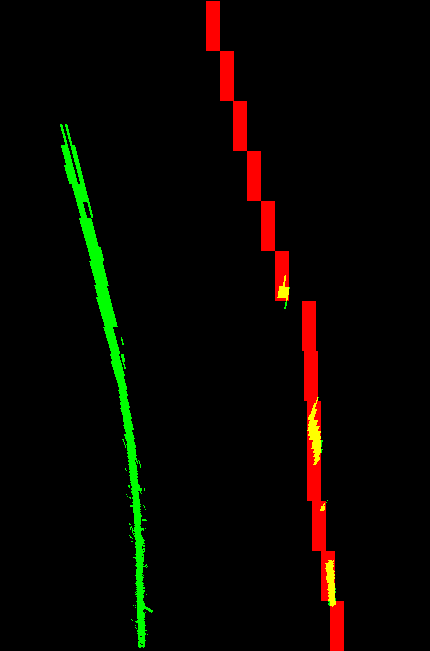

The current implementation detects abnormal return values from `argmax` and ensure that the sliding window drifts in the direction of the last step made.

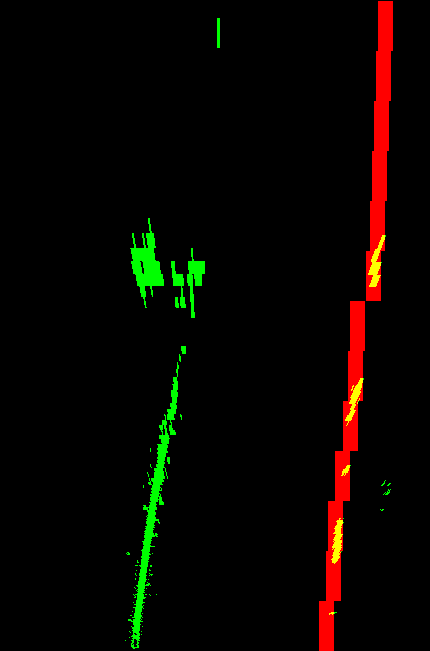

The `centroids` method is not used in the current implementation.

Another deficiency of the proposed implementation, is the choice of the pixels whose coordinates are sent to `np.polyfit`. When one is looking for lines of a given width, it is not useful to send all the pixels of a given horizontal line. As `polyfit` tries to solve X=P(Y), it will have many conflicting possible values for X for a given Y, where a function can give only one value. These contradicting equations make the least squares solution less efficient.

The replacement for `centroids` is the method called `curves`. It accepts a hint to the location of the curve and returns a fitted geometry. The width of the line we are looking for, is taken into account to create a stipple pattern. The pattern is wide enough, so that only one point per line falls in the line. The resulting set of points minimizes the number of conflicting X=P(Y) equations.

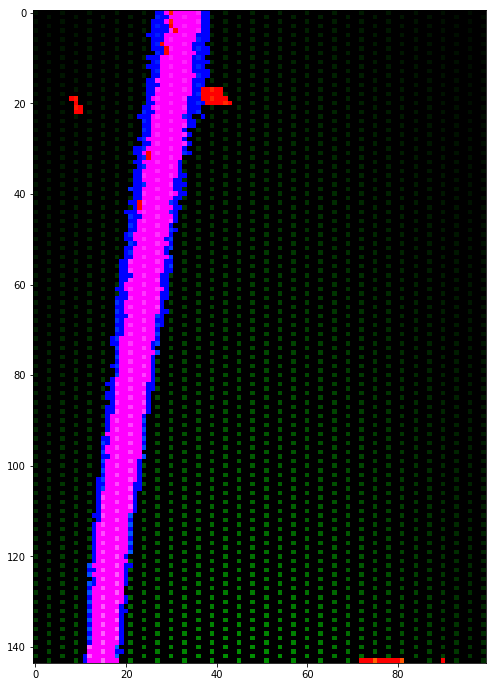

The `polyfit` function runs faster since there are fewer points to fit, but it runs as efficiently since the removed pixels would be in conflict. It is obvious that the leftover pixels must be used too. Otherwise, a vertical line would be recorded at the location of the stipple pattern rather than its own location. 

`curves` offsets the stipple pattern and call `polyfit` again until all the pixels available in the binary image have been used. In the image above, the stipple pattern has a horizontal period of 6 pixels and a vertical period of 2 pixels. The fitting operation is therefore repeated 6 times, yielding 6 geometries which are then blended together to give the solution.

The image above shows the weight mask associated to the stipple pattern as well. The weight function is used to decrease the relative importance of pixels situated far from the hint. The wide and short weight function of the illustration replaces the convolutions used in the classroom to find the start of the lane lines at the bottom of the warped image.

The weight function is a parameter to `curves`, and the one used in the pipeline is:
```python
def weight(x,y,val,x0=0.5,z0=100):
    """
    Weights of points according to location and value
    """
    # y is horizontal from reference, x is distance from camera
    # val is RGB, and binary image data can be in any layer.
    return (np.sum(val,axis=-1)+0.01)*np.exp(-x**2/z0**2)*np.exp(-y**2/x0**2)
```
It is visible that the weight function can access also the pixel values, something which is not very useful in a binary image since all the pixels defined by x and y have by definition a value of 1. `curves` is not limited to binary images, and its stipple functionality allows it to efficiently process dense images. In the current implementation, the functionality is used, but in another context.

Depending on the values of `x0` (breadth) and `z0` (distance), the search zone defined by the weight function can be very different. The next illustration show this time in red, the weight function in the context of a warped binary image (blue and red fully saturated pixels). The stipple pattern is not represented.

The initial hint when looking for the right lane line, is a straight line located 1 m right of the camera (car) centerline. The hint and the result of order 0 fitting are shown by two green vertical lines.

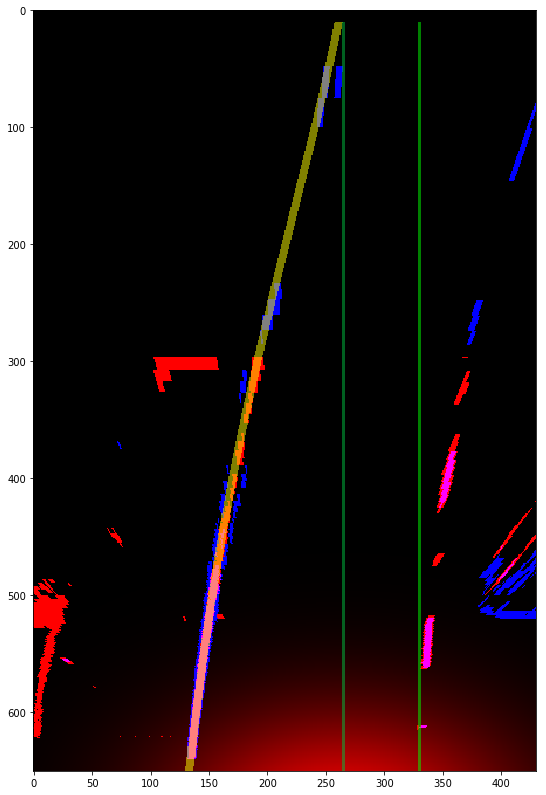

The weight function is centered around the given hint. If the lines on the left and right sides have the same number of pixels, the initial offset will make the line on the same side weight more during the fitting operation (which is just a weighted average at order 0). 

An iteration later, taking the previous result as the new hint, the exponential weight function creates a massive difference in weight in favor of the right lane line, and the fitting operation locks onto it.

The iterations and the parameterization of the weight function is decided in `find_lines` and is not part of the method `curves`.

`curves` however, provides up to 3 scores for the solution, and a reasonable estimate of how far ahead the solution is valid. In the videos, the lane overlay extension ahead of the car changes dynamically and the color of the lane varies from green to yellow to red according to the valid distance of the solutions.

It is important to monitor the performance of algorithms used for real time control. The first immediate benefit is the possibility to use simpler and faster algorithms when the job is easy, and to switch to more complex algorithms only when the scene requires it. Of course, this is not a motive in a real-time embedded system since it has to have enough computing power to run its most complex algorithm in real time. However, on my workstation, it saves time when processing the videos, and on a well designed real time embedded system, it is likely to be a good energy saving strategy.

##### Weight Score and Maximum Distance
The first score returned by `curves` is a weight score. It does not take into account the width of the line, taking instead the pixels which correspond the best to the geometry defined by the equation X=f(Y). It there is no weight function, the score is always 1.0.
Otherwise, if the weight function is based on x and y only, it measures the distance between the solution and the hint. If the weight function takes also the pixel values, if compares at the same time the distance between the solution and the hint, and how each geometry matches the lit pixels in the image. Unlit pixels have a very low weight. 

The equation X=f(Y) selects exactly one pixel per line, but `curves` only works with the Y coordinates of lit pixels. If a geometry matches a lit pixel, its score increases. This way, there is no penalty for dashed lines since the space between the dashes does not count. The hint always gets the maximum score for distance from the hint, of course, but the fitted solution is normally better at matching lit pixels. In some cases, this score can therefore be larger than one.

The per pixel weights along the fitted geometry are integrated, starting from the car. The distance at which 90% of the total weight of the geometry is reached, divided by 0.9 is deemed to be the end of the line. If the line is not well defined at long distance, or not yet well modeled by the geometry, it will only match lit pixels at close ranges and most of its weight as a solution will be concentrated there. The final division compensates proportionally for taking only 90% of the total weight. If the 'density' of the line stayed constant, the division would return its exact length.

When there is no weight function, the maximum distance is simply defined in term is maximum Y coordinate used for fitting. Unless a very narrow mask is used, it is likely to be noise.

##### Line Orientation Score
The second score rates the likelyhood of the shape of the geometry, with respect to the declared width of the line we are looking for.

Unlike the weight score, this score is inherently 3D. It relies on a subroutine named `deriv_bounds` which computes the maximum orientations of a line of a given width, for it to show as at least one pixel on the image. All the necessary camera and 3D information is available in the `CameraCalibration` instance. 

`deriv_bounds` works in camera axes: X and Y are the axes of the pixel plane, and Z extends forward. The warped image has the X axis oriented in the same direction, but Y extends forward and there is no Z. In the call of `deriv_bounds` Y can be omitted and the camera height will be used. It will be assumed that all the points for which X and Z coordinates are give, are located on the plane the car is sitting on. 

Lines radiating from the camera are easy to see far ahead. On the perspective (unwarped) image, they appear vertical. A line of the same width crossing the road perpendicularly is very quickly completely invisible, so much less than one pixel high that how wide it should be is irrelevant. Lines painted across a road, like stop bars and zebra crossings, are painted much wider to compensate.

Of course, to see perpendicular lines at a given distance, it helps to be perched high. This is an inherently 3D problem. 

The function assumes that all the line elements are in the horizontal plane. Far ahead, it will be much easier to see a line painted on a wall, than painted on the ground, but that is not the problem. For a line element located at some X, Y, Z position in camera axes, it returns the minimum and maximum orientations for which it would be possible to see that line.

For each fitted pixel, the Y coordinate (Z in camera axes) is used to compute the derivative of the curve. The derivative is compared to the lower and upper bounds computed for that location by `deriv_bounds`.

A score is computed by sorting all the pixels first by distance from the camera, second by distance from the camera axis. The first pixels with this sort order, are the most likely to pass the test.
The first pixel which fails the test is the farthest out which makes sense. For pixels even farther out, the pixels cannot belong to the fitted geometry. The score is the ratio of the index of the first pixel failing the test to the total number of fitted pixels. It is always less than one. Good solutions achieve 98% to 99% on this test.

##### Custom Score
`curves` will integrate the result of a custom scoring function in its assessment of solutions and partial solutions, if a suitable function is passed in the `sfunc` argument. 

The function is passed the `Line` instance, the key of the hint, the key of the solution to evaluate, the direction (`curves` can work in Y=f(X) and X=f(Y) modes), the x and y coordinates of the solution.

In the demonstration, the scoring function is used to achieve two goals:
* It penalizes solutions which do not start from the same position just ahead of the car (using a normal probability function);
* It computes a norm 2 distance between the hint and the solution, and return a score of 1 when the distance is zero, and lower scores down to zero when the integral is large. 

Norm 2 distance for functions is the integral of the square of the difference between the two functions (taking the square root is omitted).

When the `curves` algorithm works on successive stipple patterns, the weight associated to each partial solution is the product of those three weights. It ensures that an "unlucky" stipple pattern leading to a bad partial solution is not given a strong weight in the result.

## Camera Calibration
Before we can use the camera images (test images and videos) we have to perform the camera calibration. The next cell uses the provided calibration images to compute a set of parameters which will be used later to compensate for optical distortion.

In [3]:
import numpy as np
import cv2
import glob
from classes import RoadImage
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
corners = None

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = RoadImage(filename=fname)               # Read to RGB pixel format
    gray = img.to_grayscale()

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
 
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
# Clean up workspace: keep only objpoints and imgpoints
del corners, gray, images, objp

from classes import CameraCalibration
# Create a calibration object for images 1280x720
cal = CameraCalibration(imgpoints = imgpoints, objpoints = objpoints, img_size = img.get_size())
#cal.save('camera_cal/calibration.p')

Let's see what we have...

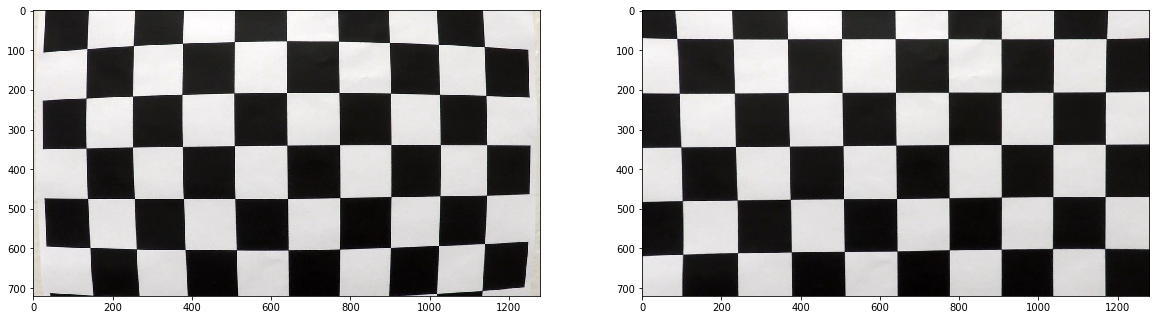

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

img = RoadImage(filename='camera_cal/calibration1.jpg')

# Do camera calibration given object points and image points
# Calibration is also relative to a given image size
#cal = CameraCalibration('camera_cal/calibration.p')

undist = img.undistort(cal)

f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax1.imshow(img)
ax2.imshow(undist)

# Look good. Save cal.
cal.save('camera_cal/calibration.p')

The code cell above creates the two lists `objpoints` and `imgpoints` of matching 3D to 2D (pixel) coordinate pairs. This data is the input of the `CameraCalibration` constructor, which calculates the parameter set we need to undistort the images and stores it in the instance `cal`. Note that 3D coordinates are in an arbitrary set of axes, and in our case, the axes are local to the chessboard pattern, giving integer coordinates (0,0,0) to (8,5,0). All the points are in the Z=0 plane, which is the plane of the chessboard.

`CameraCalibration` is part of my object oriented package 'classes'. The entire source code is available for review, but it is rather long and somewhat complex, and I have described it in great detail in this writeup.

`CameraCalibration` is a class __which never handles pixels__. It was my first class, and I copied examples from the net to see how object oriented python worked. It contains useless functionality, such as a limitation of the number of instances of the class. Those parts will be deleted (everything is under version control with Git). They haven't yet because I focused on implementing useful functionality, and those useless parts work well and do no harm.

Beyond storing the information necessary to undistort the images, the class also handles all the geometry calculations (methods `lane_start()` at line 224, and `lane()` at line 258). Of course, it was possible to finish this project with a hardcoded trapeze warped into a rectangle and back. The method `lane()` actually computes the coordinates of the trapeze and the rectangle as a function of information provided by the camera calibration:
* Camera optical center: it gives the direction the image plane is orthogonal to, and it is available in the camera calibration matrix;
* Camera x-direction and y-direction focal length, which is relative to the sensor image size and directly gives the horizontal and vertical fields of view;
* Sensor image size, which has to be provided when the calibration is made, and which we store (the size is checked for each image we undistort);
* "Ahead" vector: pointing from the camera into the forward direction of the car;

I hope that I have correctly worked out the 3D geometry problem: the camera in our case is imperfect, but not very much, and errors in my equations might be difficult to notice in the result.
* The camera sensor size is 1280 x 720 pixels;
* The geometric center of that image is at (640, 360), but the optical center is slightly offset, at (670, 386);
* The focal length corresponds to a horizontal field of view of 58° and a vertical field of view of 35°; 
* The "ahead" vector points at pixel (638,418), roughly 1.6° to the left and down of the optical center;
* The height of the camera above the ground, measured at 1.275 m using the assumption that highway lanes were exactly 3.7 meters high (note that the images might have been taken in scale model, and if we do not make an assumption regarding the real size of **something**, we cannot measure the size of anything.

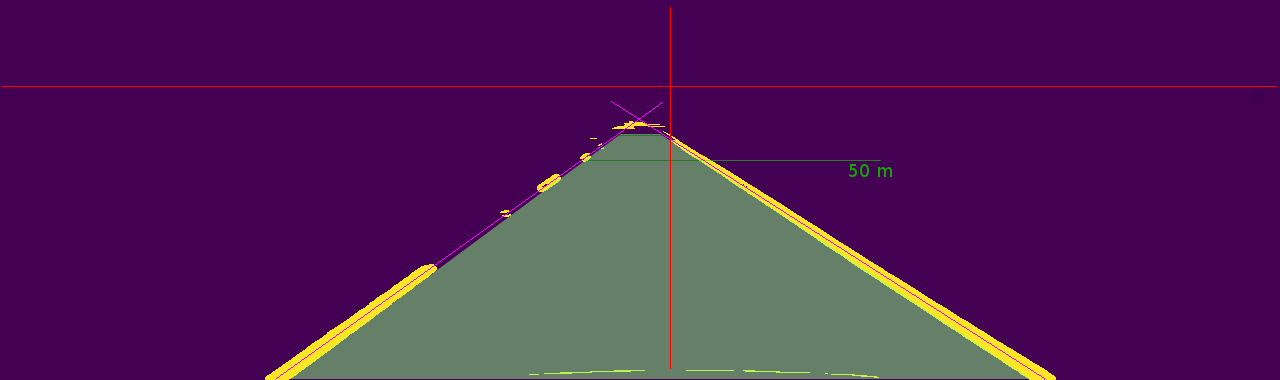

In addition to those never changing parameters (the first one depends on the camera model, the second on the camera instance, and the third and fourth mostly depend on the camera orientation and position relative to the car), the calculation depends on the relative height map, which is a height profile of the road transformed in the car axes given by the "ahead" vector. In those axes, it is not the absolute slope of the road which is described, but the increases or decreases of the slope.

The height profile is partially implemented. The video is made with the assumption of a flat road, but the slope of the road is actually changing.

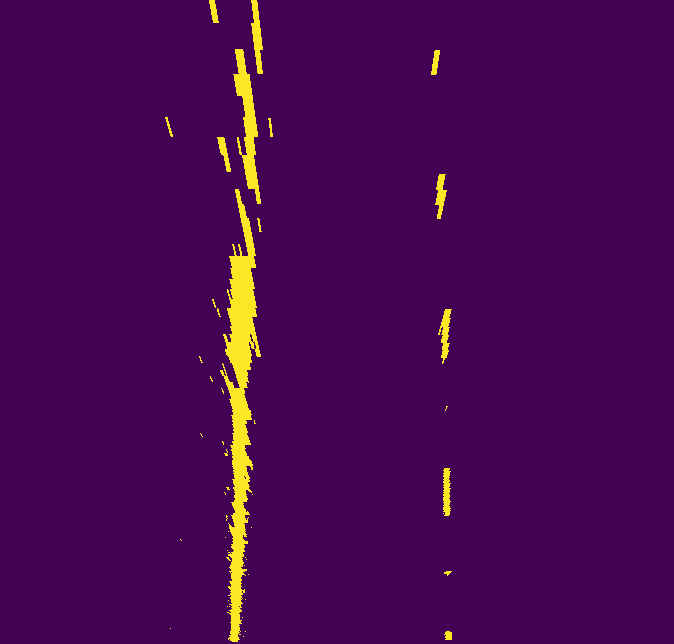

The image above is a composite image showing the lane line pixels for the `straight_lines1.jpg` test image. The scale is 2 cm/pixel in X and 10 cm/pixel in Y and the image is 644 pixels high (almost all the warped image examples use this scale, and a little bit more than 5 meters just ahead of the camera, are not visible in the images). 

It is noticeable that the lines are converging at the top, although they are parallel in reality. A small -18.6 cm correction at 70 meters from the camera makes them exactly parallel. It is reasonable to assume that the lanes are indeed parallel. With this assumption, we can interpret the varying lane width as height changes:
* The lane is too narrow when the height is negative (the road climbs less or descends more ahead);
* The lane is too wide when the height is positive (the road climbs more or descends less ahead).

Note that extracting the lane line pixels at 70 m requires a very good lane detection algorithm. Color alone will not achieve that, even in multiple colorspaces.

At line 324, you will notice that the returned rectangle is in reality a parallelogram. The trapeze is not symmetrical either, because its far end is offset since the camera points to the right of the "ahead" vector. 

I mentioned before that the optical center is important because it is the direction image planes are orthogonal to. Because the optical center is not vertically aligned with the ahead vector, those image planes do not cut the flat "road plane" (discounting the height map) on lines parallel to the X axis of the image. The top and bottom sides of the "rectangle" have a small angle because those sides are the intersection of the image planes passing at the start and the end of the depicted lane. 

Those small angles on the top and bottom sides of the "rectangle" allow the trapeze to have its top and bottom sides of course parallel to each other, but also parallel to the X direction of the image.

---

The next stage of analysis operates in a bird-eye view of the road. A view from above will make it a lot easier to calculate the geometry of the road ahead, especially the position of the car in the lane and the curvature of the road.

In order to get this view, we can rely on OpenCV's `warpPerspective` function. We will just assume that the road ahead lays in a plane having the exact same orientation as the road portion the car sits on. If this assumption isn't true, the lane lines will not be parallel, so we can possibly iterate later to fix that.

Given that assumption, an elongated rectangle of straight road ahead of the car looks like a trapeze in the camera image. We only need to find that trapeze on a suitable stretch of road, and project its four corners on the four corners of an elongated rectangle, representing the road seen from above. 

We will also take the opportunity of this projection to set the scale of the image. The height of the camera above the road sets the scale for everything else. In order to find an acceptable approximation to this figure, we will assume that the lane in the test image "straight_lines1.jpg" is exactly 3.7 meters wide. We can expect to have a lot more detail across the road, especially at short ranges, than alongside it, therefore we will employ rectangular pixels in the transformed picture. The resolution across the road must be fine enough to capture the thin lines, so we will pick 0.02 meters. In the direction of the road, 0.1 meters will be enough. A strip 10 meters wide by 70 meters long will require 500 x 700 pixels.

Some calculations using the camera matrix lead to estimates of the field of view (58°), of the height of the camera above the road and give the pixel coordinates of the vertices defining a trapezoidal area representing a 70m long lane straight ahead. Coordinates are not obvious because the camera axis is slightly offset to the right and top. 

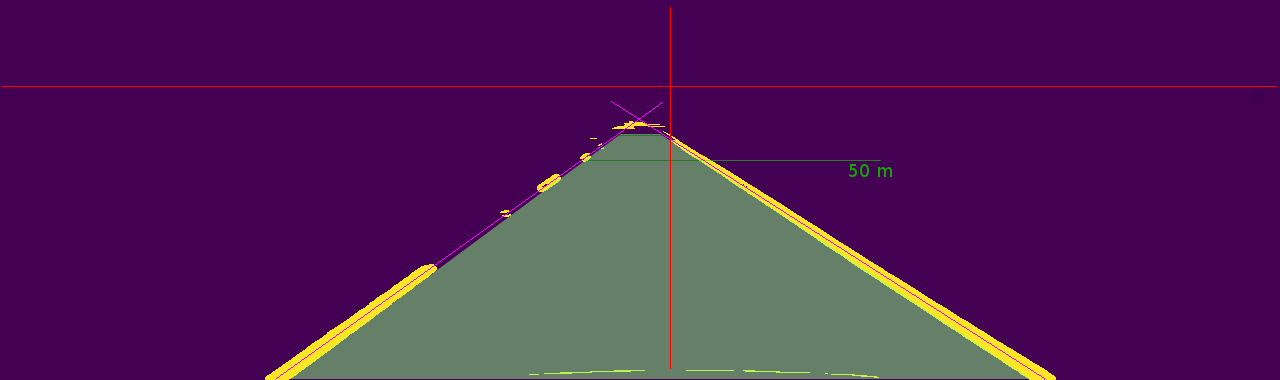

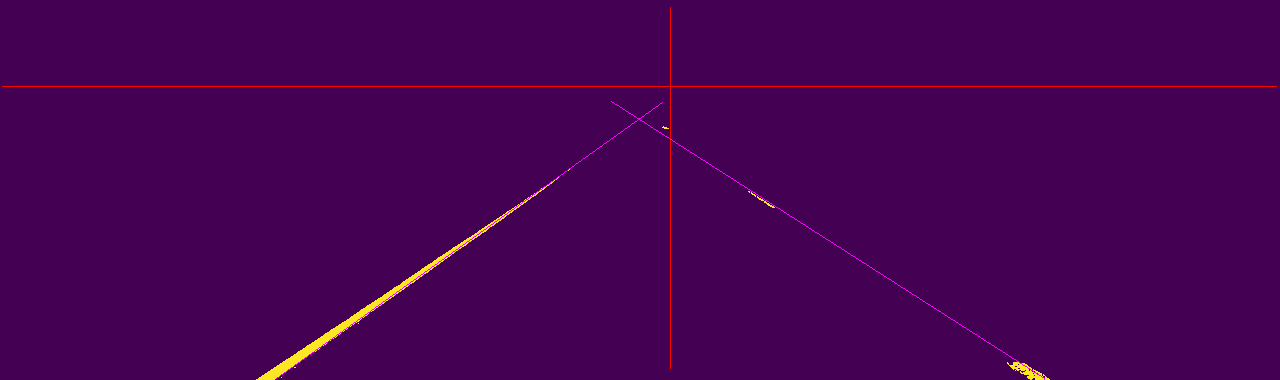

The comparison of the two straight line test images proves that it is not the trajectory of the car that obliques across the lanes. On the two figures above, which show the lanes extracted from both straight line test images, the magenta lines which are in a separate layer, superpose exactly with the lane lines in both images. The arctangent of the pixel distance, divided by the pixel focal length (found in the camera matrix), gives the angles of misalignment : the camera axis is offset roughly 1.6° to the right and the top from the straight ahead axis defined by the road.

The center of the image is also available in the camera matrix. Taking into account the cropped areas at the top and bottom, the red lines in the figures above cross at the image center, at point (x=670, y=86).

We need a known distance to calculate the scale of everything. The course teaches that the lane width is 3.7 meters. We can observe that the distance is 764 pixel horizontally. Given that those distances are in the same plane parallel to the image plane, the physical distances are proportional to the pixel distances: it gives us the height of the camera above the ground: 1.275 meters (actually the height of the camera axis as it crosses the plane).

Knowing that 3.7 meters appear as 764 pixels, we can convert the focal length to meters using proportionality. The focal length is 5.6 meters. Since the camera is not pointed straight ahead, the camera axis raises above the ground with distance with an angle of 1.6°. At z=70 meters, the small angle adds some to the camera height, which reaches 3.4 meters above the ground. The pixel offset from the image center, is equal to f y/z, using the focal length in pixels to obtain pixels. z can optionally be corrected for the small angle too.

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

persp_mat = cv2.getPerspectiveTransform(TRAPEZE,LANE)

def camera_to_birdeye(image,persp_mat):
    # Perspective transform
    birdeye_lanes = cv2.warpPerspective(image,  persp_mat, dsize=(500,700))
    return birdeye_lanes

# Demonstration
img = mpimg.imread('output_images/lines_test2.png')    # Read to RGB pixel format 

lanes = camera_to_birdeye(img[300:680],  persp_mat)

# Draw on images
for p1,p2 in zip(TRAPEZE[:3]+[0,300],TRAPEZE[1:]+[0,300]):
    cv2.line(img, tuple(p1.astype(int)), tuple(p2.astype(int)), color=[255,0,0], thickness=3)

#show_lanes = cv2.cvtColor(lanes, cv2.COLOR_GRAY2RGB)
for p1,p2 in zip(LANE[:3],LANE[1:]):
    cv2.line(lanes, tuple(p1.astype(int)), tuple(p2.astype(int)), color=[1,0,0], thickness=3)

from classes import RoadImage

print(persp_mat)

print(img.shape)    
print(lanes.shape, np.min(lanes), np.max(lanes))
# Visualize masks

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
img.view(RoadImage).show(ax1, title='Input')

The `CameraCalibration` class has the following methods:
* Management:
  * Constructor from file
  * save: save to file
* Geometry:
  * undistort: calls openCV undistort to compensate camera distortion
  * get_size: returns the size of the camera sensor in pixels
  * get_center: returns the optical center of the camera
  * focal_length: returns the focal length in pixels
  * set_ahead: set the 'ahead' direction, which is parallel to the plane the car is sitting on, and of course, straight ahead
  * get_ahead: get the 'ahead' direction, but potentially taking into account the curvature of the trajectory and the position of the camera on the vehicle
  * camera_height(property): the height of the camera above the plane the car is sitting on
  * lane_start: returns the 'ahead' direction as angles, and the distance between the camera and the first visible area of the road (which is actually blocked from view by parts of the car hood)
  * lane: returns the coordinates of the trapeze and the corresponding rectangle, ready to call `cv2.getPerspectiveTransform`
  
The last method is where the 3D geometry calculations take place. It also returns the distance between the camera and 'start of lane', the point of the supplied rectange and trapeze which is closest to the camera. 'start of lane' is around 5 meters with this car. It can never be zero since the trapeze would have to extend to infinity.

## Lane Finding Algorithm
The `process_image` function is composed of only two calls. The first to `undistort`, passing the camera calibration instance as a parameter, and the second to `RoadImage.find_lines` (RoadImage.py, line 2613).

`find_lines` implements the lane finding pipeline. It accepts road images one at a time, and returns them with a nice overlay showing the detected lane line geometries superimposed to the original lane lines. 

The lines are drawn from the start of line at the bottom of the image, to the maximum valid distance evaluated automatically. A colored tint is alpha blended between the lane lines. It extends as far ahead of the car as the shortest of the two lines, but changes color as a function of the distance at which the algorithm 'sees' the lines. If is fully green when the requested distance is achieved (the line are tracked from the bottom to the top of the warped image), and becomes fully red when the lines cannot be reliably detected beyond 10 meters. The color scale is linear.

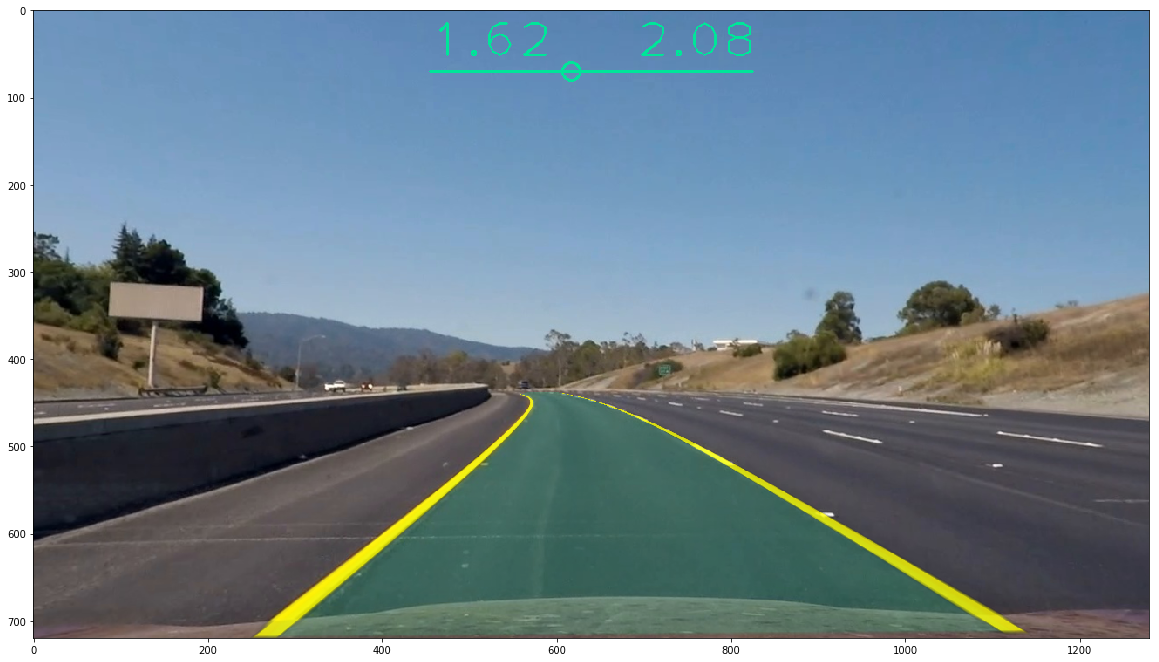

In addition a HUD like green display shows additional information. In the top center, a bar changes as the measured lane width (since the lane width is constant, it actually moves very little in reaction to changes in the height of the camera above the ground). The numbers at the left and right ends of the bar, indicate the distance between the car and the corresponding lane line. The small circle on the bar gives the same information graphically in proportion to the width of the lane.

When the lane curves, an indication 'R= xxx m' appears on the side the road turns to. It indicates the radius of curvature measured by the program. The radius of curvature is only displayed when it is less than 2 km. 

The radius of curvature and the left and right line length are passed through low pass filters, whose state is maintained from frame to frame, in order to stabilize the values for the viewer. Without the stabilization, the radius of curvature would be jumping around a lot.

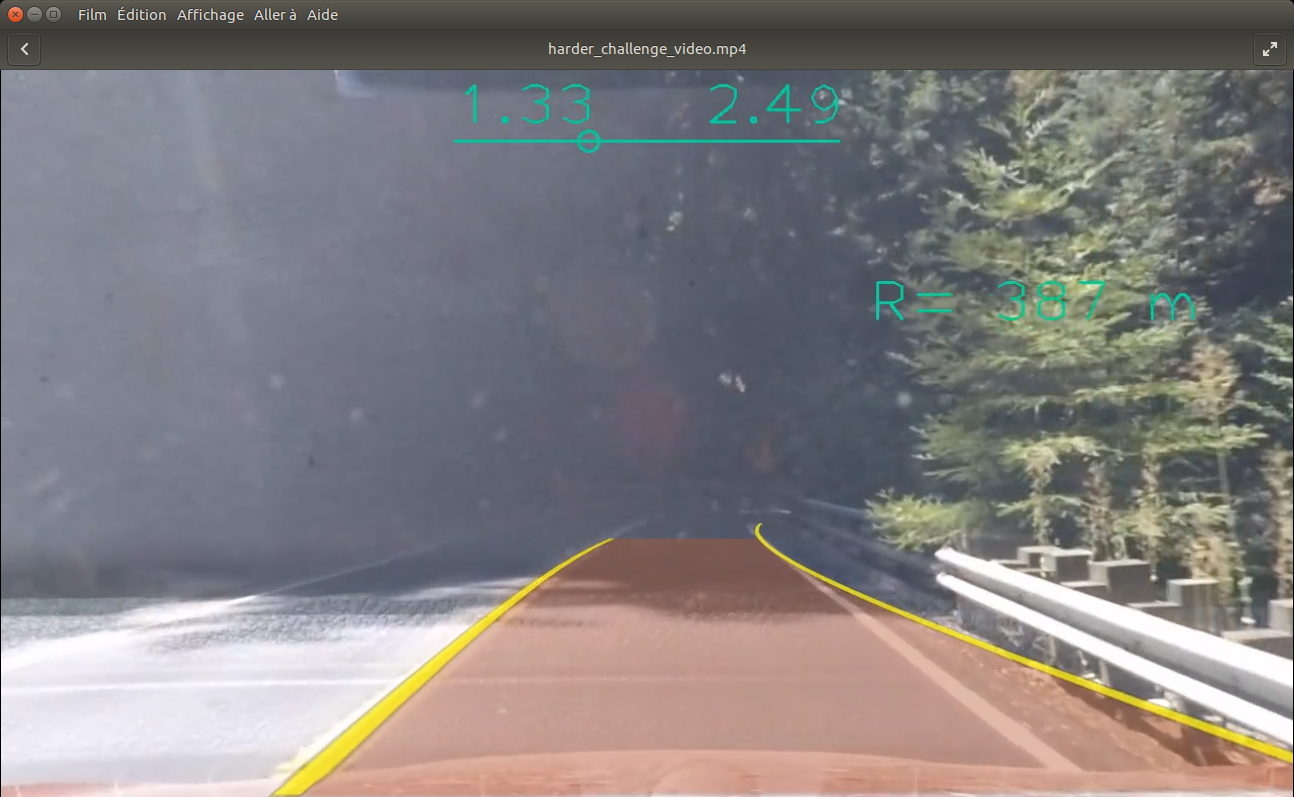

`find_lines` relies on `curves` but implements important parts of the algorithm itself.

Unlike the classroom solution which models the lane lines as 2nd order polynomials, `find_lines` tries to reach order 4. Order 3 is skipped since it describes mostly undesirable swerving solutions. 

The following animated GIF illustrates how the algorithm works, when it starts from default hints, 1 meter to the left and to the right of the car.

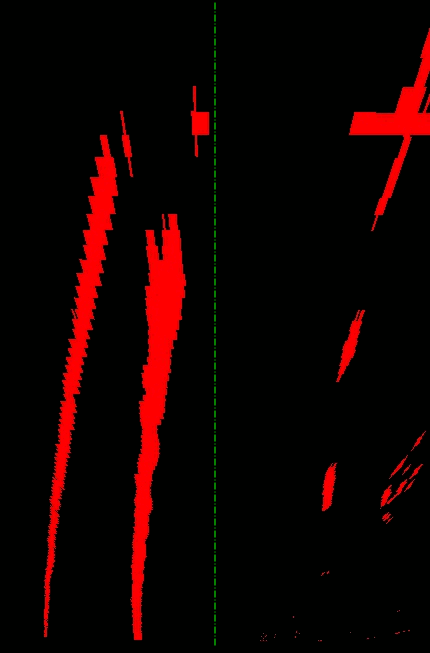

While `curves` works with weight functions, `find_lines` uses masks to eliminate noise pixels in several stages. Because the roadside is less visible at very short range, the algorithm initially combines a very broad mask with a short range weight function, in order to find where the lines start.

The subroutine `estimates` always returns something, based on historic data kept in the `state.lines` instance of `LinePoly`. When there is no history, for instance for the first frame, `estimates` (RoadImage.py, line 2715) returns the default hints. The default hints are order 0 solutions, and have a default evaluation of 0.001.

When historic data exists for the line, `estimates` averages the order and the evaluations achieved by those solutions. In can return a fractional order, since order means just complexity. All the code specific to polynomial solutions is contained in `LinePoly.py`. The stored evaluation scores are also used as weights to blend a weighted average of the geometry (line 2788).

Since I used the `moviepy.editor.VideoFileClip` function to generate the videos in a single run, `find_lines` was receiving each image in a distinct, unrelated instance of `RoadImage`. The first few lines of the method look for a specific attribute `slstate` on that instance, and failing to find it, recover the current state stored in a static variable. The static variable is a global variable, therefore it should not be used when processing several video streams at once.

The method has 5 tunable parameters, which can optionally be initialized in the state record:
* zmax: the distance which corresponds to the top line of the warped image, and also the farthest distance at which the algorithm will attempt to detect lane lines
* keepnext: the number of past frames to average in `estimates`, in order to make the hint for the current video frame
* keepdraw: the drawn lines are actually results given by `estimates` as well, and we can arbitrarily choose to average a different number of past geometries (typically less than to make the hint)
* journal: if set to a file name, triggers logging of all the polynoms, their order, zmax, and evaluations, to help debugging the algorithm
* track: if set to True, makes the function store every mask, line, or other 2D element useful to debug the algorithm.

Since storing all the intermediate image takes a lot of disk space and slows down the computations, it is possible to store a frame number in track, and the intermediate images will only be stored for the corresponding frame.

The following images are stored:
* The initial binary image and the modified version after each line is found
* The masks
* The result of applying the mask to the binary image to remove noise
* Each solution subjected to evalution (they are traced in a buffer at line 2687)

The method detects the first time it is called because its state vector is incomplete. It displays the tunable parameters and initializes the rest of the state vector. The state vector include the state of the low pass filters for the curvature and the line lengths, implemented using `scipy.signal.lfilter`.

The input image is then cropped from the 'ahead' direction, to the hood of the car (which on undistorted images starts after line 656).

The next block tries to update the curvature, only if there is stored historic data. The block (lines 2887-2912) computes the information and feeds the low-pass filters. The filtered data is what gets displayed at the end.

Then the frame counter is increased. The macro `curK` implicitly references the frame counter. The next few lines define partial methods to warp and unwarp images, which are used by `Line.draw` and `Line.draw_area`, when they are called to draw geometries on camera images. The geometries are always drawn in warped (top view) buffers with anti-aliasing, then unwarped and alpha blended in the camera image. This approach avoids the loss of quality which would result if we directly warped and unwarped the camera image. It also lets us work around a limitation of openCV, which cannot natively do alpha blending.

`Line.draw` is used to draw the yellow overlay lane lines in the final rendering, but is also used to draw the masks and other lines in the algorithm (without warping). A lot of optimisation is still possible there. For instance, the lane and the two lane lines could be drawn in the same warped buffer, and alpha blended in one operation instead of three.

The block between lines 2930 and 2960 is the image preprocessing, which has already been described. Then, `estimates` is called to initialize the current geometries with hints based on history.

Unlike the classroom algorithm, which had a specific algorithm to start, and reused past geometries for the following frames, there is no distinct bootstrap phase in `find_lines`. There are four stages, named order 0, 1, 2, and 4, and the algorithm will start with the stage given by the estimates. The very first call to `estimates` always returns the default hints, which are order 0. Subsequent calls may return up to order 2 hints (which correspond to second order polynomials when using `LinePoly` to describe the geometries).


At line 2967 starts the loop on the lines. The lines are not always processed in the same order. `estimates` can return the lines with the best evaluation first. When a lane line is fitted with a high degree of confidence, `find_lines` erases it (line 3075) from the warped binary image, since it becomes noise for the detection of the remaining lines (which can be dashed lines, and are more difficult to find).

The loop defined initial values and sets a maximum of 5 stages for the inner loop. This limit is higher than the number of stages, because it allows restarting at a very low stage when that seems the best chance of finding a line.

The middle loop at line 2978 iterates on the stages, trying to get the solution from order 0 (a line start) to order 4 (a fourth order polynomial). Its first part (lines 2981-2989) does the actual choice of the stage we are attempting. `find_lines` uses both order and evaluation to decide where to start for the current frame, but can also attempt a restart at order 0 with default hints if `curves` fails completely for example.

For each stage, there is of course a corresponding solution 'complexity' (polynom order), but also specific values for the weight function parameters. The illustrations below show the corresponding weight functions (red cloud), the initial and final solution (green).

Stage 1:   order=0
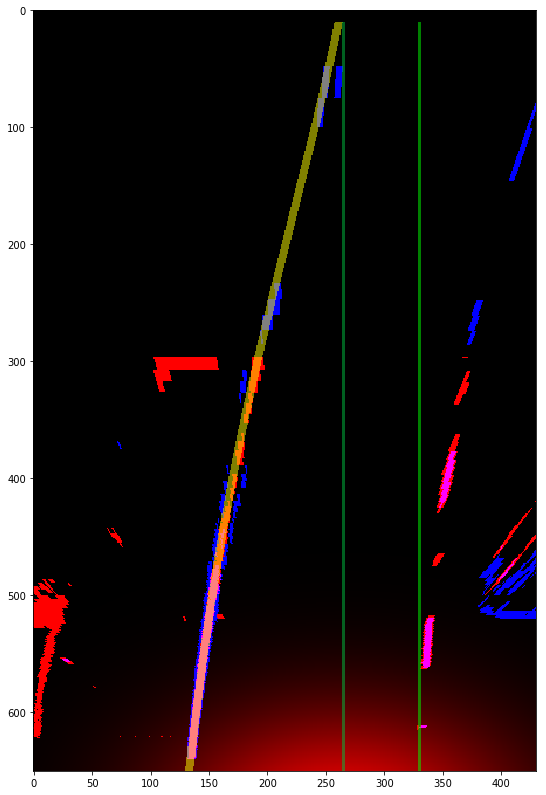

Stage 2:   order=1
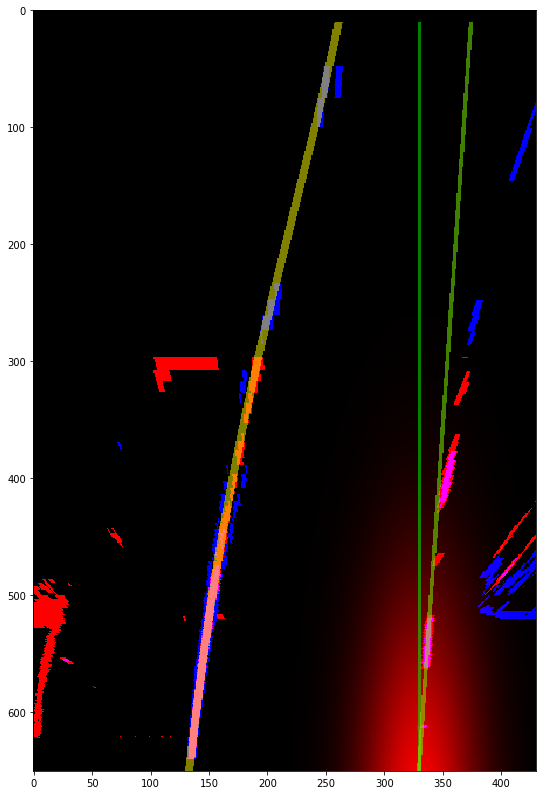

Stage 3:   order=2
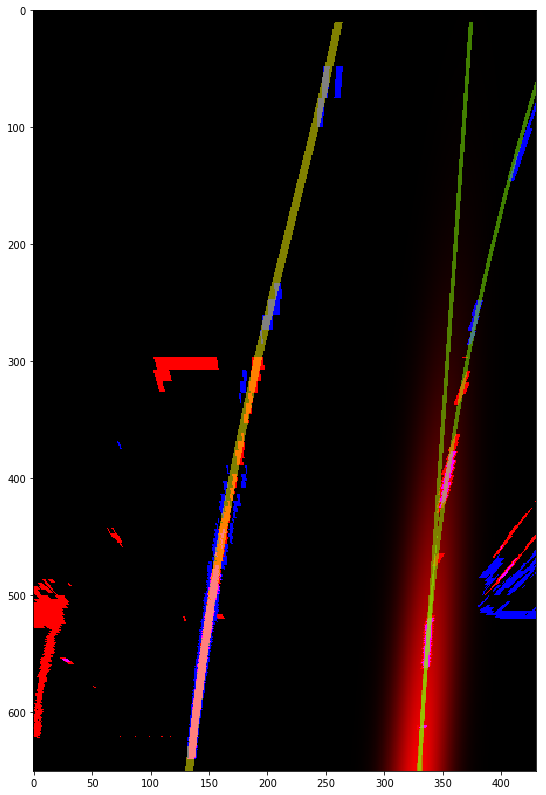

Stage 4:   order=4
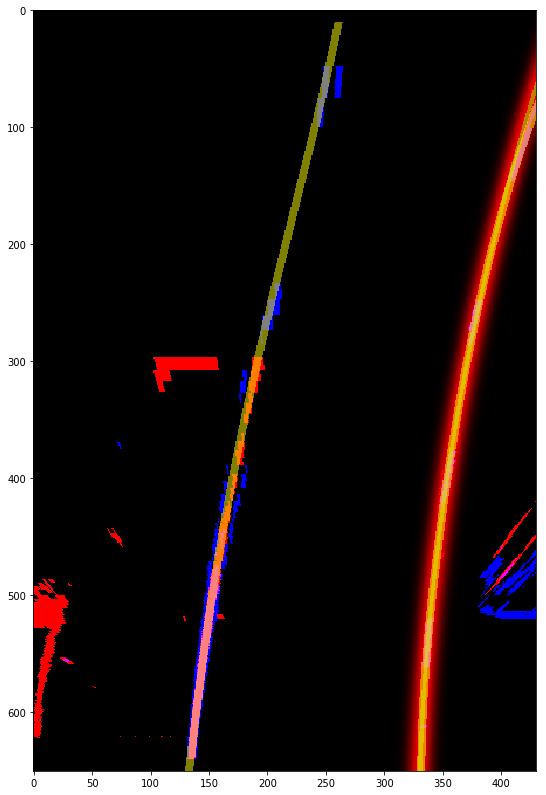

`find_lines` then draws and applies a mask corresponding to the hint. The mask width also depends on the stage, from 3 meters at stage 1 down to 1 meter at stages 3 and 4.

Finally the hint or the stage iteration is evaluated as a solution and saved as the best currently known solution, and the inner loop is entered.

The inner loop iterates at a given stage, until specific conditions are met. At order zero, the maximum number of iteration is 10, because a few extra iterations may be needed to lock on the base of the lane line. During those iterations, the evaluations are typically lower than 0.05. 

Iterations are stopped when:
* The maximum number of iterations has been reached (3 after the first stage)
* The evaluation of the current solution falls 10% below the best recorded solution
* The solution ceases to improve, and meets the minimum evaluation for the next stage

If the solution is not improving very quickly the weight function shape is modified to be more selective on the sides, and to reach farther ahead. This is helpful to catch the first dash, when the first dash is at its farthest possible position. Without this adaptative feature, the algorithms locks on random noise very close to the car.

When the loop exists, a decision is made:
* If the global improvement measured by evaluation was more than 10%, continue for three more iterations at the same stage
* Else if we are at order 4, we have finished : that's where the algorithm erases the line from the binary image. A reasonably narrow 1 meter strip is erased, in order to cover some imprecision on noise which sometimes happen a long ranges
* Else if we have collapsed to 80% of the solution we had before the inner loop or less, `find_lines` eliminates the solution from the historic data: there will be no solution for this frame and line, but since `estimates` always returns a solution, it will not prevent drawing the overlay.

If none of those branches is taken, the stage counter is decreased and the algorithm tries again at the same stage. The algorithm may fail to reach stage 4, and can deliver a lower order solution. This situation happens when the maximum number of stage iterations (5) has been reached before stage 4 is achieved.

The final part of the function measures the lane width, applies corrections to the positions of the left and right line lanes, abd finally displays the HUD data and the overlay.

## Discussion
I encountered many difficulties while doing this project. Most are directly link to the size of the program (4000 lines of code, plus 1000 lines of validation code) combined with my inexperience of Python.
The trickiest bug I found involved two seemingly float valued variables. I narrowed it to a line where a small number was added to one of the two variables. The other variable changed simultaneously. When I got to that point after hours of research (the bug affected the hints, making it impossible to continue from stage 4 hints) it was quite obvious that some form of variable aliasing was taking place. In fact, rather than being floats, those variables were numpy numbers, or actually references to the same numpy number. And unlike floats, numpy numbers are mutable...

Debugging was also very difficult until I discovered pdb. I should have made that Google search earlier.

Another major difficulty was the preprocessing. The difficulty is not technical, since there is no good or correct solution. I used Keras to optimise the thresholds, so that the selected pixels would match the pixels I had annotated manually on the test images. Keras did the job of optimizing all the thresholds, but at the end of the day, the pipeline is slightly less effective at finding the line pixels, than the much simpler preprocessing algorithm from the project walkthrough.

The pipeline has been tried on the challenge and harder challenge videos. The challenge video includes an underpass where the road is locally in a dark shadow. The image preprocessing fails to isolate the line pixels. I attempted to increase the contrast using per line image normalization, but it did not work, so the preferred solution is to cross that area using historic data.  

Increasing the tunable parameters keepnext and keepdraw to XX does the job, but introduces a noticeable lag in the response.

With the same simple preprocessing, the harder challenge video raises additional difficulties: the shadows projected by the trees are irregular and the white line is often covered by dead tree leaves. `find_lines` fails to track the lane on that video. It might be made more robust if the processing of the left and right lines was interconnected. They are currently tracked completely independently, but we may use a generic information on the lane width to generate hints for the line which is the most difficult to see.

If the lane lines are treated as a discontinuous detection, they can be used as corrective input to a Kalman filter, which will rely on a continuously available source line an inertial sensor. GPS and most external sensors are also considered as discontinuous.

In [4]:
from classes import RoadImage, CameraCalibration,Line
from classes.decorators import static_vars
import numpy as np

cal = CameraCalibration('camera_cal/validation.p')
# Set the camera harmonization parameters for our car.
cal.set_camera_height(1.275)
cal.set_ahead(638,418)

@static_vars(counter=0, img=None)
def process_image(image):
    if process_image.img is None:
        process_image.img = RoadImage(image, src_cspace='RGB')
    else:
        np.copyto(process_image.img, image)
    # Save crash image (in case of crash)
    process_image.img.save('output_images/crash.jpg', format='jpg')
    # Do the work
    process_image.counter += 1
    overlay = process_image.img.find_lines(cal, method = RoadImage.centroids, save=True)
    overlay.save('output_images/videos/image%04d.png' 
                 % process_image.counter)
    out = overlay.to_int().copy()
    del overlay
    return out

AttributeError: 'CameraCalibration' object has no attribute 'set_camera_height'

origin = [215 700]
scoring: 0 -2.43263452431 0.268461751248
DEBUG: p(0,0)= ([15.608377960865795, -2.8460413593667733, 0.041340683505983813, 0.0],)
scores: cust=0.27  weight=0.04  derbounds=0.19
scoring: 0 -0.478390089958 0.950414447988
DEBUG: p(1,0)= ([3.7731598392498982, -0.55958903666703252, 0.0081198946708906702, 0.0],)
scores: cust=0.95  weight=0.08  derbounds=0.54
scoring: 0 -0.504347358159 0.94504206898
DEBUG: p(2,0)= ([3.9356992902761347, -0.58966112835641626, 0.0085313770196958037, 0.0],)
scores: cust=0.95  weight=0.08  derbounds=0.52
scoring: 0 -0.83183118065 0.857473386783
DEBUG: p(3,0)= ([5.7886963445004129, -0.97332416907439168, 0.014149298842421896, 0.0],)
scores: cust=0.86  weight=0.06  derbounds=0.35
scoring: 0 -0.00976179195542 0.999978824095
DEBUG: p(4,0)= ([0.77705585133362987, -0.011633784488619245, 0.00018719925332004255, 0.0],)
scores: cust=1.00  weight=0.62  derbounds=0.94
scoring: 0 -0.750965338101 0.882212796281
DEBUG: p(5,0)= ([5.3205511315158756, -0.8784627168

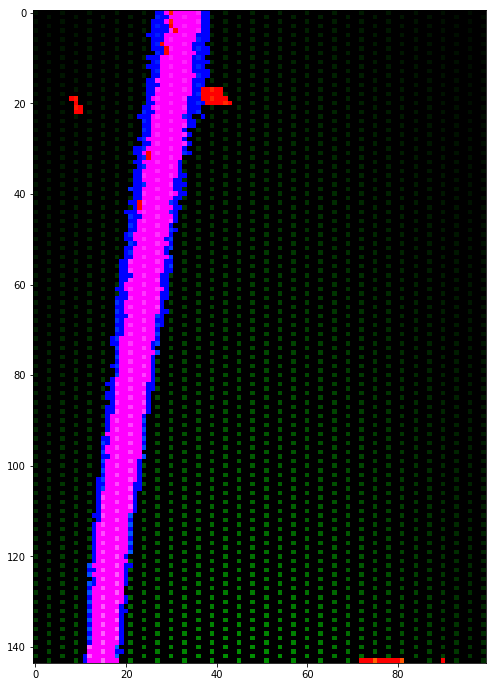

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
image = RoadImage(filename='test_images/test6.jpg')
image = process_image(image)

image=image.to_float()

width = 0.12
sx,sy = (.02,.1)
o = (215,700)

stepx = max(int(width/sx),2)
stepy = max(int(width/sy),2)
startx = stepx//2
starty = stepy//2
iterx  = stepx - startx
itery  = stepy - starty
#iters = ( (x,y) for y in range(1,651,stepy) for x in (3,430,stepx) )
w1 = np.array([ [ weight(y=(x-o[0])*sx+1,x=(o[1]-y)*sy,x0=1,z0=10.) for x in range(3,430,stepx) ] for y in range(1,651,stepy)])
w2 = np.array([ [ weight(y=(x-o[0])*sx+1,x=(o[1]-y)*sy,x0=1,z0=10.) for x in range(3+startx,430,stepx) ] for y in range(1+starty,651,stepy)])

image.view(np.ndarray)[1::stepy,3::stepx,1]=w1
image.view(np.ndarray)[1+starty::stepy,3+startx::stepx,1]=w2
image = image[500:644,120:220]
#image = image[1::stepy,3::stepx]

f, ax1 = plt.subplots(1,1, figsize=(20,12))
image.show(ax1)

In [15]:
with open('ramdisk/debug.csv','w') as f:
    f.write('"key";"index";"eval";"zmax";"order";"poly"\n')
    for K in RoadImage.find_lines.state.lines:
        poly = RoadImage.find_lines.state.lines.stats(K,'poly')
        data = RoadImage.find_lines.state.lines.stats(K,'eval','zmax','order')
        data = list(data)
        if len(K)>1:data.append(K[1])
        else:   data.append(0)
        poly = [ str(k) for k in poly]
        data = [ str(k) for k in data]
        msg = ';'.join([data[3],data[0],data[1],data[2],poly[0],poly[1],poly[2],poly[3],poly[4]])
    
        f.write('"'+str(K)+'";'+msg.replace('.',',')+'\n')


In [36]:
RoadImage.find_lines.__code__

<code object gsearch_wrapper at 0x7fc7701480c0, file "/home/jm/Projets/Udacity/CarND-Advanced-Lane-Lines/classes/decorators.py", line 193>

Separation... avoids scrolling

Initialization.
    keepnext = 16
    journal = ramdisk/debug.csv
    keepdraw = 8
Initializing left line.
Initializing right line.


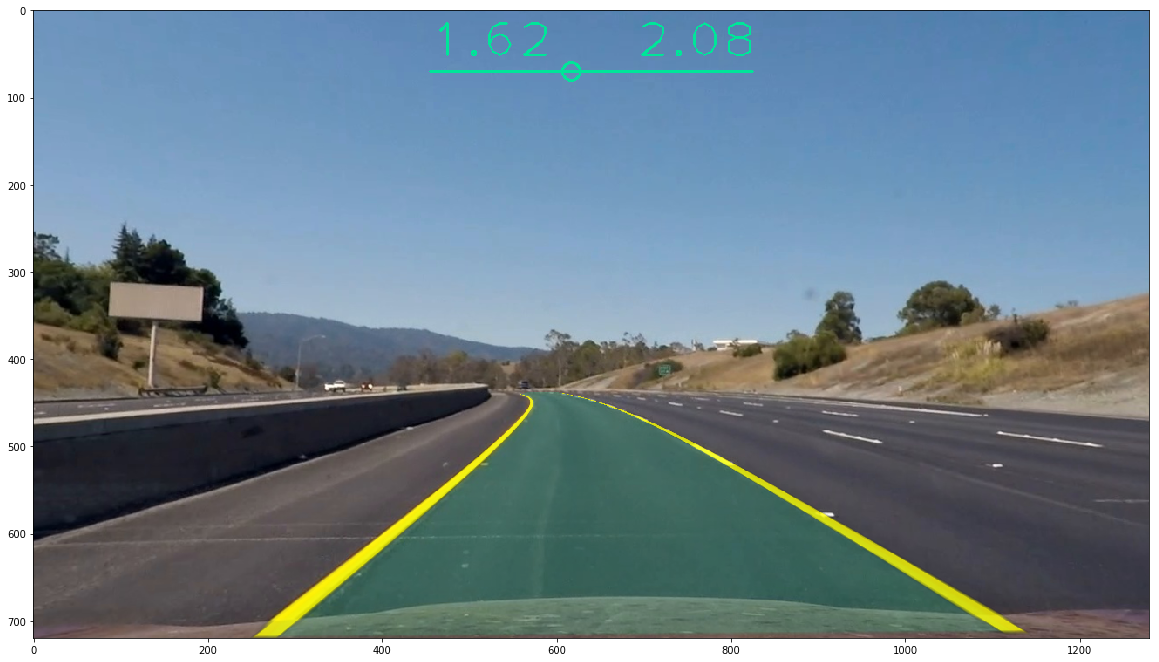

In [2]:
import numpy as np
import pdb
#%pdb

def myweight(x,y,x0=0.5,z0=100):
    return np.exp(-x**2/z0**2)*np.exp(-y**2/x0**2)

def plotweight(img, key, origin, scale, x0, z0):
    if not(img.lines.exist(key)): return
    w,h = img.get_size()
    ox,oy = origin
    sx,sy = scale
    for y in range(h):
        x=(oy-y)*sy
        yref = img.lines.eval(key,z=x)
        xx = np.arange(w)
        yy = np.ones_like(xx)*y
        weights = myweight(y=(xx-ox)*sx-yref,x=(oy-yy)*sy,x0=x0,z0=z0)
        img[y,:,1] = np.maximum(img[y,:,1], weights)
        
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial

#file='input0001'
file='input0073'
#file='input0604'
#file='input1210'
#file='input1230'
#file='test1'
#file='test5'
#file='input0135'

image = RoadImage(filename='test_images/'+file+'.jpg')
#process_image.state=None
image = process_image(image)

f, ax1 = plt.subplots(1,1, figsize=(20,14))
image.show(ax1)

Warning: About to reinitialize!

In [1]:
from classes import CameraCalibration, RoadImage
from classes.decorators import static_vars
import pdb
#%pdb
cal = CameraCalibration('camera_cal/validation.p')
# Set the camera harmonization parameters for our car.
cal.camera_height=1.2
cal.set_ahead(638,418)

class State(object):
    pass

# Tunables
RoadImage.find_lines.state = State()
RoadImage.find_lines.state.counter  = 0
RoadImage.find_lines.state.keepdraw = 24
RoadImage.find_lines.state.keepnext = 24
#RoadImage.find_lines.state.journal = 'ramdisk/debug.csv'
#RoadImage.find_lines.state.track = True
#with open(RoadImage.find_lines.state.journal, 'w') as f:
#    f.write('"key";"index";"eval";"zmax";"order";"poly"\n')

@static_vars(state=None)
def process_image(image):
    img = RoadImage(image, src_cspace='RGB')
    img = img.undistort(cal)
    #img.normalize(inplace=True, perchannel=False, perline=True)

    img = img.find_lines(cal)

    process_image.state = RoadImage.find_lines.state
    return img

Make the video.

In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pdb
%pdb
def debug_signal_handler(signal, frame):
    import pdb
    pdb.set_trace()
import signal
signal.signal(signal.SIGINT, debug_signal_handler)

#file = 'project_video.mp4'
#file = 'harder_challenge_video.mp4'
file = 'challenge_video.mp4'

output = 'output_images/'+file
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(file).subclip(37,42)
#clip1 = VideoFileClip(file).subclip(33,38)
#clip1 = VideoFileClip(file).subclip(37,38)
#clip1 = VideoFileClip(file).subclip(20,25)
clip1 = VideoFileClip(file)
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

Automatic pdb calling has been turned ON
Initialization.
    keepdraw = 24
    keepnext = 24
Initializing left line.
Initializing right line.
Lost sync! ev 0.1327 < 0.2039 initial_eval
Lost sync! ev 0.3625 < 0.4730 initial_eval
Initializing left line.
Initializing right line.
[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4


  0%|          | 0/485 [00:00<?, ?it/s]

Lost sync! ev 0.1327 < 0.2039 initial_eval
Lost sync! ev 0.3625 < 0.4730 initial_eval


  0%|          | 1/485 [00:02<21:24,  2.65s/it]

Lost sync! ev 0.1419 < 0.2017 initial_eval
Lost sync! ev 0.3412 < 0.5023 initial_eval


  0%|          | 2/485 [00:05<20:40,  2.57s/it]

Lost sync! ev 0.1437 < 0.1991 initial_eval
Lost sync! ev 0.3448 < 0.4853 initial_eval


  1%|          | 3/485 [00:07<21:08,  2.63s/it]

Lost sync! ev 0.1345 < 0.1901 initial_eval
Lost sync! ev 0.3302 < 0.4679 initial_eval


  1%|          | 4/485 [00:10<21:11,  2.64s/it]

Lost sync! ev 0.1379 < 0.1753 initial_eval
Lost sync! ev 0.3332 < 0.4810 initial_eval


  1%|          | 5/485 [00:12<20:09,  2.52s/it]

Lost sync! ev 0.1383 < 0.1993 initial_eval
Lost sync! ev 0.3618 < 0.4809 initial_eval


  1%|          | 6/485 [00:15<20:12,  2.53s/it]

Lost sync! ev 0.1628 < 0.2126 initial_eval
Lost sync! ev 0.3152 < 0.4517 initial_eval


  1%|▏         | 7/485 [00:18<22:21,  2.81s/it]

Lost sync! ev 0.1387 < 0.2135 initial_eval
Lost sync! ev 0.2778 < 0.4471 initial_eval


  2%|▏         | 8/485 [00:21<21:40,  2.73s/it]

Lost sync! ev 0.1596 < 0.2199 initial_eval
Lost sync! ev 0.3078 < 0.4095 initial_eval


  2%|▏         | 9/485 [00:24<21:44,  2.74s/it]

Lost sync! ev 0.2319 < 0.4065 initial_eval


  2%|▏         | 10/485 [00:26<20:52,  2.64s/it]

Lost sync! ev 0.2923 < 0.4024 initial_eval


  2%|▏         | 11/485 [00:28<19:34,  2.48s/it]

Lost sync! ev 0.2893 < 0.3620 initial_eval


  2%|▏         | 12/485 [00:31<19:48,  2.51s/it]

Lost sync! ev 0.2728 < 0.3598 initial_eval


  3%|▎         | 14/485 [00:35<18:33,  2.36s/it]

Lost sync! ev 0.2355 < 0.3103 initial_eval


  3%|▎         | 16/485 [00:38<15:30,  1.98s/it]

Lost sync! ev 0.2292 < 0.2878 initial_eval


  4%|▎         | 17/485 [00:40<15:37,  2.00s/it]

Lost sync! ev 0.2056 < 0.2686 initial_eval


  4%|▎         | 18/485 [00:42<15:26,  1.98s/it]

Lost sync! ev 0.1928 < 0.2697 initial_eval


  7%|▋         | 35/485 [01:12<13:51,  1.85s/it]

Lost sync! ev 0.1929 < 0.2519 initial_eval


 10%|▉         | 48/485 [01:37<12:44,  1.75s/it]

StopIteration BUG : order = 2.


 19%|█▉        | 93/485 [03:40<19:48,  3.03s/it]

Lost sync! ev 0.0329 < 0.1223 initial_eval


 20%|█▉        | 95/485 [03:48<24:02,  3.70s/it]

Lost sync! ev 0.3653 < 0.4582 initial_eval
Lost sync! ev 0.0300 < 0.0874 initial_eval


 20%|█▉        | 96/485 [03:52<24:11,  3.73s/it]

Lost sync! ev 0.0385 < 0.0676 initial_eval


 20%|██        | 97/485 [03:56<23:43,  3.67s/it]

Lost sync! ev 0.0504 < 0.0639 initial_eval


 20%|██        | 99/485 [04:02<21:29,  3.34s/it]

Lost sync! ev 0.0389 < 0.0659 initial_eval


 21%|██        | 101/485 [04:08<21:19,  3.33s/it]

Lost sync! ev 0.0372 < 0.0616 initial_eval


 21%|██        | 103/485 [04:12<16:18,  2.56s/it]

Lost sync! ev 0.0740 < 0.1216 initial_eval


 23%|██▎       | 112/485 [04:34<12:08,  1.95s/it]

Lost sync! ev 0.0457 < 0.0736 initial_eval


 25%|██▍       | 119/485 [04:44<08:58,  1.47s/it]

Lost sync! ev 0.0418 < 0.1562 initial_eval


 27%|██▋       | 131/485 [05:13<15:34,  2.64s/it]

Lost sync! ev 0.0422 < 0.0549 initial_eval


 28%|██▊       | 135/485 [05:23<13:43,  2.35s/it]

Lost sync! ev 0.0254 < 0.0322 initial_eval


 34%|███▍      | 164/485 [06:24<11:23,  2.13s/it]

Lost sync! ev 0.0210 < 0.0272 initial_eval


 34%|███▍      | 167/485 [06:32<14:00,  2.64s/it]

Lost sync! ev 0.6167 < 0.7758 initial_eval


 35%|███▍      | 168/485 [06:36<16:50,  3.19s/it]

StopIteration BUG : order = 2.


 35%|███▍      | 169/485 [06:40<17:22,  3.30s/it]

Lost sync! ev 0.5819 < 0.7462 initial_eval


 35%|███▌      | 171/485 [06:49<20:17,  3.88s/it]

Lost sync! ev 0.5630 < 0.7522 initial_eval


 36%|███▌      | 174/485 [07:00<19:52,  3.84s/it]

Lost sync! ev 0.5376 < 0.7222 initial_eval


 61%|██████▏   | 298/485 [15:46<15:39,  5.02s/it]

Lost sync! ev 0.0344 < 0.0952 initial_eval


 62%|██████▏   | 301/485 [15:59<13:34,  4.43s/it]

Lost sync! ev 0.3505 < 0.4404 initial_eval


 69%|██████▉   | 337/485 [18:01<08:05,  3.28s/it]

Lost sync! ev 0.3536 < 0.4431 initial_eval


 86%|████████▌ | 416/485 [21:35<02:22,  2.06s/it]

StopIteration BUG : order = 2.


100%|██████████| 485/485 [23:41<00:00,  1.65s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video.mp4 

CPU times: user 26min 21s, sys: 27min 50s, total: 54min 11s
Wall time: 23min 42s
